In [1]:
import os
os.chdir('./../..')
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad_datasets import AscadDataset
from models.lstm import LstmModel

In [2]:
train_dataset = AscadDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = AscadDataset(train=False)
test_dataloader = DataLoader(test_dataset, batch_size=64)
loss_fn = nn.MSELoss()

In [3]:
train_loss_vals = {}
test_loss_vals = {}
train_max_dist = {}
test_max_dist = {}

n_epochs = 100

for delay in [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    print('Delay:', delay)
    model = LstmModel(64, 3, delay=delay).cuda()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    train_loss_vals.update({delay: []})
    test_loss_vals.update({delay: []})
    train_max_dist.update({delay: []})
    test_max_dist.update({delay: []})
        
    for epoch in tqdm(range(n_epochs)):
        for batch in train_dataloader:
            trace, _ = batch
            trace = trace.cuda()
            logits = model(trace)
            loss = loss_fn(logits, trace)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
            optimizer.step()
            train_loss_vals[delay].append(loss.detach().cpu().numpy())
            max_dist = np.mean(np.max(np.abs(trace.detach().cpu().numpy()-logits.detach().cpu().numpy()), axis=1))
            train_max_dist[delay].append(max_dist)
        with torch.no_grad():
            for batch in test_dataloader:
                trace, _ = batch
                trace = trace.cuda()
                logits = model(trace)
                loss = loss_fn(logits, trace)
                test_loss_vals[delay].append(loss.cpu().numpy())
                max_dist = np.mean(np.max(np.abs(trace.cpu().numpy()-logits.cpu().numpy()), axis=1))
                test_max_dist[delay].append(max_dist)
        train_loss_vals[delay][epoch] = np.mean(train_loss_vals[delay][epoch:])
        train_max_dist[delay][epoch] = np.mean(train_max_dist[delay][epoch:])
        test_loss_vals[delay][epoch] = np.mean(test_loss_vals[delay][epoch:])
        test_max_dist[delay][epoch] = np.mean(test_max_dist[delay][epoch:])
        del train_loss_vals[delay][epoch+1:]
        del train_max_dist[delay][epoch+1:]
        del test_loss_vals[delay][epoch+1:]
        del test_max_dist[delay][epoch+1:]

Delay: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:02<00:00, 37.83s/it]


Delay: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:24<00:00, 38.05s/it]


Delay: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:33<00:00, 38.13s/it]


Delay: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:31<00:00, 38.12s/it]


Delay: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:33<00:00, 38.14s/it]


Delay: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:31<00:00, 38.12s/it]


Delay: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:35<00:00, 38.16s/it]


Delay: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:33<00:00, 38.13s/it]


Delay: 128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:25<00:00, 38.06s/it]


Delay: 256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:32<00:00, 38.12s/it]


Delay: 512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:31<00:00, 38.11s/it]


In [4]:
import pickle
import os

with open(os.path.join('.', 'results', 'lstm_autoencoder_delay_sweep', 'data.pickle'), 'wb') as F:
    pickle.dump({
        'train_l2_dists': train_loss_vals,
        'test_l2_dists': test_loss_vals,
        'train_sup_dists': train_max_dist,
        'test_sup_dists': test_max_dist
    }, F)

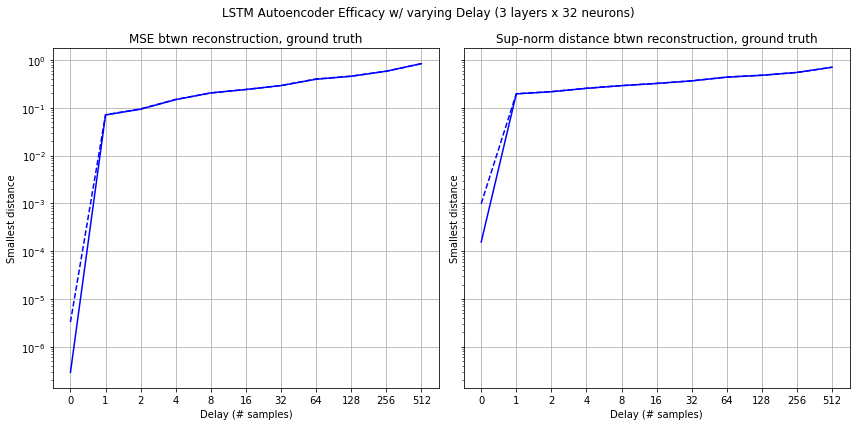

In [5]:
delays = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
train_losses = []
test_losses = []
train_dists = []
test_dists = []
for d in delays:
    train_losses.append(np.min(train_loss_vals[d]))
    test_losses.append(np.min(test_loss_vals[d]))
    train_dists.append(np.min(train_max_dist[d]))
    test_dists.append(np.min(test_max_dist[d]))

(fig, axes) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].plot(range(len(delays)), train_losses, linestyle='--', color='blue')
axes[0].plot(range(len(delays)), test_losses, linestyle='-', color='blue')
axes[1].plot(range(len(delays)), train_dists, linestyle='--', color='blue')
axes[1].plot(range(len(delays)), test_dists, linestyle='-', color='blue')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel('Delay (# samples)')
axes[1].set_xlabel('Delay (# samples)')
axes[0].set_ylabel('Smallest distance')
axes[1].set_ylabel('Smallest distance')
axes[0].set_title('MSE btwn reconstruction, ground truth')
axes[1].set_title('Sup-norm distance btwn reconstruction, ground truth')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_xticks(range(len(delays)))
axes[1].set_xticks(range(len(delays)))
axes[0].set_xticklabels(delays)
axes[1].set_xticklabels(delays)
fig.suptitle('LSTM Autoencoder Efficacy w/ varying Delay (3 layers x 32 neurons)')
plt.tight_layout()
fig.savefig(os.path.join('.', 'results', 'lstm_autoencoder_delay_sweep', 'best_performance.pdf'))

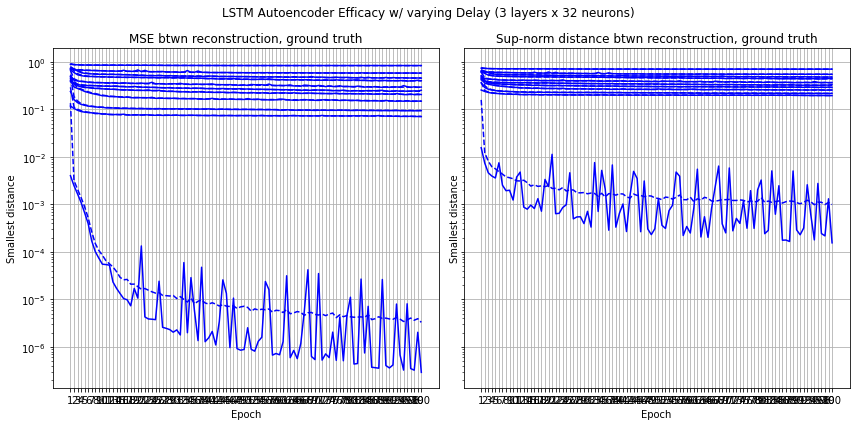

In [6]:
(fig, axes) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
epochs = np.arange(1, 101)
for _, trace in train_loss_vals.items():
    axes[0].plot(epochs, trace, linestyle='--', color='blue')
for _, trace in test_loss_vals.items():
    axes[0].plot(epochs, trace, linestyle='-', color='blue')
for _, trace in train_max_dist.items():
    axes[1].plot(epochs, trace, linestyle='--', color='blue')
for _, trace in test_max_dist.items():
    axes[1].plot(epochs, trace, linestyle='-', color='blue')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
axes[0].set_ylabel('Smallest distance')
axes[1].set_ylabel('Smallest distance')
axes[0].set_title('MSE btwn reconstruction, ground truth')
axes[1].set_title('Sup-norm distance btwn reconstruction, ground truth')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_xticks(epochs)
axes[1].set_xticks(epochs)
axes[0].set_xticklabels(epochs)
axes[1].set_xticklabels(epochs)
fig.suptitle('LSTM Autoencoder Efficacy w/ varying Delay (3 layers x 32 neurons)')
plt.tight_layout()
fig.savefig(os.path.join('.', 'results', 'lstm_autoencoder_delay_sweep', 'training_curves.pdf'))